# Pneumonia X-Ray Image Classification

This project aims to build a deep neural network that trains using x-ray images of pediatric patients to identify whether or not they have pneumonia. The dataset comes from Kermany et al. on Mendeley on Kaggle: https://www.kaggle.com/andrewmvd/pediatric-pneumonia-chest-xray

This project will follow the OSEMN data science process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.datasets import mnist
from keras import regularizers, initializers, optimizers
import os
import datetime
from keras.wrappers.scikit_learn import KerasRegressor
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict

## Obtain Data

First, bring in images for training and test sets.

In [3]:
# Create directory paths
train_data_dir = 'data/Pediatric Chest X-ray Pneumonia/train'
test_data_dir = 'data/Pediatric Chest X-ray Pneumonia/test'

# Get all the test data and reshape them (255,255)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, batch_size=624, target_size=(255,255))

# Get all the train data and reshape them (255,255)
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, batch_size=5232, target_size=(255,255))

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


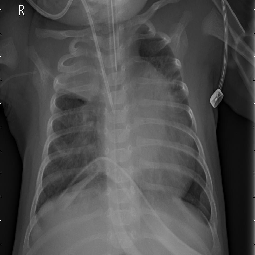

In [4]:
array_to_img(train_images[621])

Images are (255, 255, 3) arrays that contain pixel values (0-255) to represent color.

In [5]:
train_images[621]

array([[[ 28.,  28.,  28.],
        [ 28.,  28.,  28.],
        [ 28.,  28.,  28.],
        ...,
        [ 33.,  33.,  33.],
        [ 41.,  41.,  41.],
        [ 53.,  53.,  53.]],

       [[ 28.,  28.,  28.],
        [ 28.,  28.,  28.],
        [ 29.,  29.,  29.],
        ...,
        [ 35.,  35.,  35.],
        [ 43.,  43.,  43.],
        [ 57.,  57.,  57.]],

       [[ 28.,  28.,  28.],
        [ 28.,  28.,  28.],
        [ 30.,  30.,  30.],
        ...,
        [ 37.,  37.,  37.],
        [ 46.,  46.,  46.],
        [ 61.,  61.,  61.]],

       ...,

       [[ 14.,  14.,  14.],
        [ 14.,  14.,  14.],
        [ 14.,  14.,  14.],
        ...,
        [ 61.,  61.,  61.],
        [ 78.,  78.,  78.],
        [108., 108., 108.]],

       [[ 14.,  14.,  14.],
        [ 14.,  14.,  14.],
        [ 14.,  14.,  14.],
        ...,
        [ 61.,  61.,  61.],
        [ 78.,  78.,  78.],
        [108., 108., 108.]],

       [[ 14.,  14.,  14.],
        [ 14.,  14.,  14.],
        [ 14.,  

The labels for train and test data are an array of (1x2) arrays that indicate whether a patient has pneumonia. A 1 in the first position indicates healthy while a 1 in the second position indiciates pnuemonia. Each (1x2) array must have exactly one '1' and one '0'

In [10]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [7]:
# Preview the shape of both the images and labels for both the train and test sets (4 objects total)
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5232, 255, 255, 3)
(5232, 2)
(624, 255, 255, 3)
(624, 2)


## Scrub & Explore Data

**Reshaping Image Data**

In order to use this data for modeling, we need to reshape these images, which are currently matrices, into vectors. In this case, we concatenate each row into a single vector, doing this consistently for each image. For example, there are 5232 images with (255,255,3) dimensions in the train set, so the resulting matrix would be (5232,255x255x3) ie. (5232, 195075)

In [4]:
X_train = train_images.reshape(5232, 195075).astype('float32')
X_test = test_images.reshape(624, 195075).astype('float32')

In [9]:
X_train.shape

(5232, 195075)

**Editing labels**

Next, we can reduce labels to a single column. Because a '1' in the second position indicates pneumonia, by default, those patients will have a '0' in the first position. If we eliminated the first column of the labels, we get a single column with a '1' indicating pneumonia and a '0' indicating healthy (no pneumonia).

In [5]:
train_labels = train_labels.T[[1]]
test_labels = test_labels.T[[1]]

train_labels = train_labels.T
test_labels = test_labels.T

**Normalizing Image Data**

One last change is to normalize image data by dividing each entry in an image by 255. What this does is it ensures that every pixel number in an image is now between 0 and 1, which is easier to work with.

In [6]:
X_train /= 255.
X_test /= 255.

**Preparing Data for Modeling**

We want our test set to be completely independent of any modeling decisions so we will create a validation set which will act as the "test" set that will be used at each iteration of improving our model. In this case, we want the sizes of the validation and test set to be a 60-40 split, respectively.

In [7]:
X_final_test, X_val, y_final_test, y_val = train_test_split(X_test, test_labels, random_state=3, train_size=.4)

## Modeling

**Model Callbacks**

In [60]:
# early stopping callback after 3 consecutive iterations with no improvement to loss
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# model checkpoint call back
checkpoint_filepath = 'model_checkpoints/init_model/weights-improvement--{val_acc:.2f}.hdf5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               monitor='val_acc',
                                                               mode='max',
                                                               verbose=1,
                                                               save_best_only=True)

In [60]:
import tensorflow.python.keras.backend as K
from keras import initializers
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel.initializer'):
            layer.kernel.initializer.run(session=session)

**Function for Viewing Model Results**

In [9]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

### Neural Networks

**Initial Model**

In [71]:
%reset_selective -f init

In [72]:
init_model = Sequential()
init_model.add(Dense(64, activation='relu', input_shape=(195075,)))
init_model.add(Dense(1, activation='sigmoid'))
init_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [73]:
init_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                12484864  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,484,929
Trainable params: 12,484,929
Non-trainable params: 0
_________________________________________________________________


In [74]:
init_results = init_model.fit(X_train, train_labels, epochs=163, batch_size=32, validation_data=(X_val, y_val),
                             callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/163
163/164 [============================>.] - ETA: 0s - loss: 0.8251 - acc: 0.7373
Epoch 00001: val_acc did not improve from 0.60267
164/164 [==============================] - 9s 52ms/step - loss: 0.8237 - acc: 0.7372 - val_loss: 0.4959 - val_acc: 0.6027
Epoch 2/163
164/164 [==============================] - ETA: 0s - loss: 0.3835 - acc: 0.7630
Epoch 00002: val_acc improved from 0.60267 to 0.73867, saving model to model_checkpoints/init_model/weights-improvement--0.74.hdf5
164/164 [==============================] - 9s 52ms/step - loss: 0.3835 - acc: 0.7630 - val_loss: 0.5386 - val_acc: 0.7387
Epoch 3/163
164/164 [==============================] - ETA: 0s - loss: 0.3166 - acc: 0.8828
Epoch 00003: val_acc did not improve from 0.73867
164/164 [==============================] - 8s 49ms/step - loss: 0.3166 - acc: 0.8828 - val_loss: 0.9873 - val_acc: 0.6720
Epoch 4/163
164/164 [==============================] - ETA: 0s - loss: 0.3041 - acc: 0.8849
Epoch 00004: val_acc improved from 

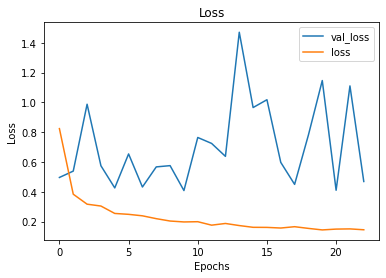

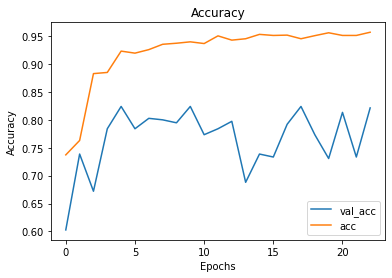

In [77]:
visualize_training_results(init_results)

**Comments**

Judging from the visualizations, this model seems pretty overfit. Our options moving forward are to add layer weight initializers (random normal, random uniform), regularizers, and dropouts. We can also try other optimizers (SGD, Adam, rmsprop). We should avoid adding new layers as it seems already overfit.

**Adding Regularizers**

In [81]:
%reset_selective -f reg

In [84]:
reg_model = Sequential()
reg_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(195075,)))
reg_model.add(Dense(1, activation='sigmoid'))
reg_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [85]:
checkpoint_filepath = 'model_checkpoints/reg_model/weights-improvement--{val_acc:.2f}.hdf5'

In [87]:
reg_results = reg_model.fit(X_train, train_labels, epochs=163, batch_size=32, validation_data=(X_val, y_val),
                             callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/163
164/164 [==============================] - ETA: 0s - loss: 1.3899 - acc: 0.7580
Epoch 00001: val_acc did not improve from 0.82400
164/164 [==============================] - 13s 80ms/step - loss: 1.3899 - acc: 0.7580 - val_loss: 1.6224 - val_acc: 0.3973
Epoch 2/163
164/164 [==============================] - ETA: 0s - loss: 1.2641 - acc: 0.7387
Epoch 00002: val_acc did not improve from 0.82400
164/164 [==============================] - 12s 71ms/step - loss: 1.2641 - acc: 0.7387 - val_loss: 1.4099 - val_acc: 0.6027
Epoch 3/163
164/164 [==============================] - ETA: 0s - loss: 0.9908 - acc: 0.7422
Epoch 00003: val_acc did not improve from 0.82400
164/164 [==============================] - 11s 70ms/step - loss: 0.9908 - acc: 0.7422 - val_loss: 1.3253 - val_acc: 0.6027
Epoch 4/163
164/164 [==============================] - ETA: 0s - loss: 0.9044 - acc: 0.7422
Epoch 00004: val_acc did not improve from 0.82400
164/164 [==============================] - 12s 74ms/step - loss

Epoch 32/163
164/164 [==============================] - ETA: 0s - loss: 0.3891 - acc: 0.9516
Epoch 00032: val_acc did not improve from 0.83733
164/164 [==============================] - 11s 69ms/step - loss: 0.3891 - acc: 0.9516 - val_loss: 0.9879 - val_acc: 0.7813
Epoch 33/163
164/164 [==============================] - ETA: 0s - loss: 0.3855 - acc: 0.9528
Epoch 00033: val_acc did not improve from 0.83733
164/164 [==============================] - 11s 70ms/step - loss: 0.3855 - acc: 0.9528 - val_loss: 1.1842 - val_acc: 0.7573
Epoch 34/163
164/164 [==============================] - ETA: 0s - loss: 0.3874 - acc: 0.9444
Epoch 00034: val_acc did not improve from 0.83733
164/164 [==============================] - 12s 73ms/step - loss: 0.3874 - acc: 0.9444 - val_loss: 0.9520 - val_acc: 0.7733
Epoch 35/163
164/164 [==============================] - ETA: 0s - loss: 0.3598 - acc: 0.9539
Epoch 00035: val_acc did not improve from 0.83733
164/164 [==============================] - 12s 76ms/step - 

Epoch 63/163
164/164 [==============================] - ETA: 0s - loss: 0.2271 - acc: 0.9595
Epoch 00063: val_acc did not improve from 0.83733
164/164 [==============================] - 12s 73ms/step - loss: 0.2271 - acc: 0.9595 - val_loss: 0.5751 - val_acc: 0.8187
Epoch 64/163
164/164 [==============================] - ETA: 0s - loss: 0.2179 - acc: 0.9627
Epoch 00064: val_acc did not improve from 0.83733
164/164 [==============================] - 14s 84ms/step - loss: 0.2179 - acc: 0.9627 - val_loss: 0.5632 - val_acc: 0.8347
Epoch 65/163
164/164 [==============================] - ETA: 0s - loss: 0.2224 - acc: 0.9608
Epoch 00065: val_acc did not improve from 0.83733
164/164 [==============================] - 12s 74ms/step - loss: 0.2224 - acc: 0.9608 - val_loss: 1.3343 - val_acc: 0.7333
Epoch 66/163
164/164 [==============================] - ETA: 0s - loss: 0.2224 - acc: 0.9593
Epoch 00066: val_acc did not improve from 0.83733
164/164 [==============================] - 12s 72ms/step - 

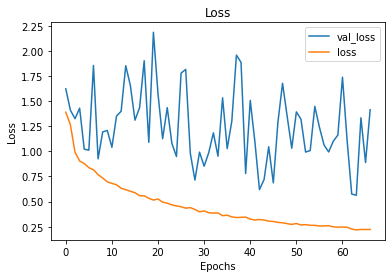

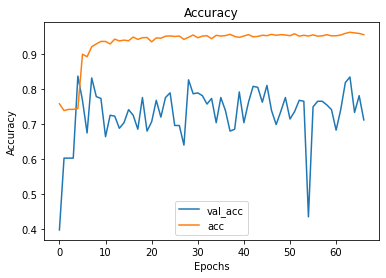

In [88]:
visualize_training_results(reg_results)

**Comments**

No noticeable change. Model is still very overfit. 

**Adding Dropout**

In [90]:
dp_model = Sequential()
dp_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(195075,)))
dp_model.add(Dropout(0.3))
dp_model.add(Dense(1, activation='sigmoid'))
dp_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [91]:
dp_results = dp_model.fit(X_train, train_labels, epochs=163, batch_size=32, validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/163
164/164 [==============================] - 18s 109ms/step - loss: 1.3462 - acc: 0.7339 - val_loss: 1.1459 - val_acc: 0.6027
Epoch 2/163
164/164 [==============================] - 14s 88ms/step - loss: 1.0281 - acc: 0.7664 - val_loss: 1.1329 - val_acc: 0.6453
Epoch 3/163
164/164 [==============================] - 14s 82ms/step - loss: 0.9401 - acc: 0.8668 - val_loss: 1.0514 - val_acc: 0.7973
Epoch 4/163
164/164 [==============================] - 14s 87ms/step - loss: 0.9440 - acc: 0.8379 - val_loss: 1.1329 - val_acc: 0.7653
Epoch 5/163
164/164 [==============================] - 14s 88ms/step - loss: 0.9007 - acc: 0.8618 - val_loss: 1.5125 - val_acc: 0.6267
Epoch 6/163
164/164 [==============================] - 17s 106ms/step - loss: 0.8653 - acc: 0.8639 - val_loss: 1.0558 - val_acc: 0.8107
Epoch 7/163
164/164 [==============================] - 18s 112ms/step - loss: 0.8502 - acc: 0.8679 - val_loss: 1.0727 - val_acc: 0.7627
Epoch 8/163
164/164 [==============================]

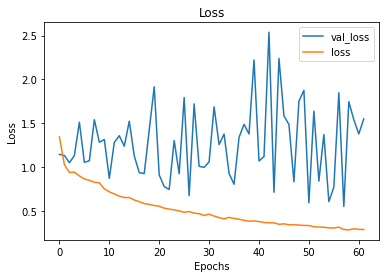

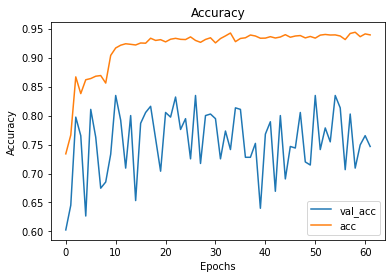

In [92]:
visualize_training_results(dp_results)

**Comments**

Judging from the visualizations, this model still seems pretty overfit. Next, trying layer weight initializers may help, but deep neural networks are not ideally suited for image classification, so I would not be surprised if it does not fix the overfittedness.

**Adding Initializers**

In [12]:
%reset_selective -f inz

In [13]:
inz_model = Sequential()
inz_model.add(Dense(64, activation='relu', kernel_initializer=initializers.RandomNormal(),
                   kernel_regularizer=regularizers.l2(0.005), input_shape=(195075,)))
inz_model.add(Dropout(0.3))
inz_model.add(Dense(1, activation='sigmoid'))
inz_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [14]:
inz_results = inz_model.fit(X_train, train_labels, epochs=163, batch_size=32, validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/163
164/164 [==============================] - 14s 85ms/step - loss: 154.3048 - acc: 0.7963 - val_loss: 151.5681 - val_acc: 0.7867
Epoch 2/163
164/164 [==============================] - 12s 74ms/step - loss: 149.0055 - acc: 0.8567 - val_loss: 146.6495 - val_acc: 0.7947
Epoch 3/163
164/164 [==============================] - 11s 66ms/step - loss: 144.1743 - acc: 0.8804 - val_loss: 142.1430 - val_acc: 0.7120
Epoch 4/163
164/164 [==============================] - 11s 69ms/step - loss: 139.4986 - acc: 0.8924 - val_loss: 137.4151 - val_acc: 0.8000
Epoch 5/163
164/164 [==============================] - 12s 72ms/step - loss: 134.9890 - acc: 0.8997 - val_loss: 133.4488 - val_acc: 0.7173
Epoch 6/163
164/164 [==============================] - 13s 77ms/step - loss: 130.6076 - acc: 0.9213 - val_loss: 128.8875 - val_acc: 0.7813
Epoch 7/163
164/164 [==============================] - 12s 70ms/step - loss: 126.3927 - acc: 0.9188 - val_loss: 124.9407 - val_acc: 0.7680
Epoch 8/163
164/164 [======

Epoch 120/163
164/164 [==============================] - 11s 68ms/step - loss: 3.2978 - acc: 0.9448 - val_loss: 4.4233 - val_acc: 0.7467
Epoch 121/163
164/164 [==============================] - 11s 64ms/step - loss: 3.1845 - acc: 0.9480 - val_loss: 3.9419 - val_acc: 0.7867
Epoch 122/163
164/164 [==============================] - 10s 63ms/step - loss: 3.1049 - acc: 0.9419 - val_loss: 4.0611 - val_acc: 0.7600
Epoch 123/163
164/164 [==============================] - 11s 68ms/step - loss: 3.0066 - acc: 0.9415 - val_loss: 4.5292 - val_acc: 0.7227
Epoch 124/163
164/164 [==============================] - 12s 71ms/step - loss: 2.9167 - acc: 0.9373 - val_loss: 3.3464 - val_acc: 0.8160
Epoch 125/163
164/164 [==============================] - 11s 65ms/step - loss: 2.8072 - acc: 0.9539 - val_loss: 3.6004 - val_acc: 0.7920
Epoch 126/163
164/164 [==============================] - 11s 66ms/step - loss: 2.7301 - acc: 0.9488 - val_loss: 3.6059 - val_acc: 0.7707
Epoch 127/163
164/164 [==================

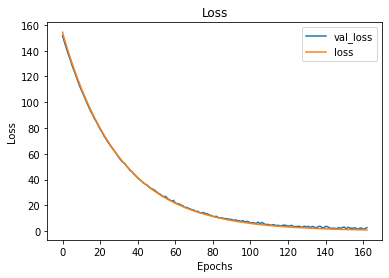

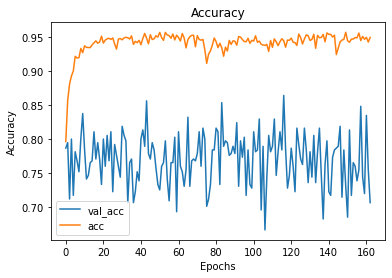

In [16]:
visualize_training_results(inz_results)

**Comments**

For this model, accuracy exhibited the same overfit pattern, but loss seems to have improved. However, this may be because the early stopping criteria was not triggered and thus all 164 epochs were carried out. The last thing to try could be switching SGD for Adam.

**Different Optimizer: Adam**

In [17]:
adam_model = Sequential()
adam_model.add(Dense(64, activation='relu', kernel_initializer=initializers.RandomNormal(),
                   kernel_regularizer=regularizers.l2(0.005), input_shape=(195075,)))
adam_model.add(Dropout(0.3))
adam_model.add(Dense(1, activation='sigmoid'))
adam_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
adam_results = adam_model.fit(X_train, train_labels, epochs=163, batch_size=32, validation_data=(X_val, y_val),
                             callbacks=[early_stopping])

Epoch 1/163
164/164 [==============================] - 16s 99ms/step - loss: 89.0606 - acc: 0.7232 - val_loss: 49.7176 - val_acc: 0.6507
Epoch 2/163
164/164 [==============================] - 16s 99ms/step - loss: 35.0565 - acc: 0.7366 - val_loss: 23.3162 - val_acc: 0.6507
Epoch 3/163
164/164 [==============================] - 19s 115ms/step - loss: 16.4259 - acc: 0.7422 - val_loss: 11.1004 - val_acc: 0.6507
Epoch 4/163
164/164 [==============================] - 21s 128ms/step - loss: 7.8446 - acc: 0.7422 - val_loss: 5.3417 - val_acc: 0.6507
Epoch 5/163
164/164 [==============================] - 21s 128ms/step - loss: 3.8088 - acc: 0.7422 - val_loss: 2.6849 - val_acc: 0.6507
Epoch 6/163
164/164 [==============================] - 17s 103ms/step - loss: 1.9572 - acc: 0.7422 - val_loss: 1.5250 - val_acc: 0.6507
Epoch 7/163
164/164 [==============================] - 16s 98ms/step - loss: 1.1725 - acc: 0.7422 - val_loss: 1.0586 - val_acc: 0.6507
Epoch 8/163
164/164 [========================

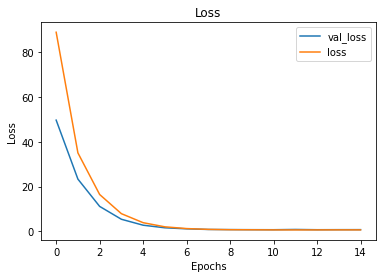

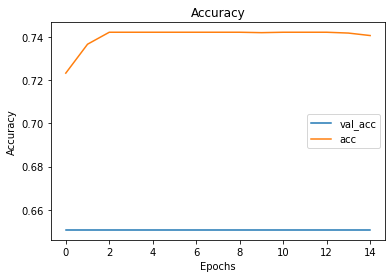

In [19]:
visualize_training_results(adam_results)

**Comments**

While the loss seems to converge for both the training and validation, the validation accuracy remained constant throughout. It is time to move onto CNN (Convolutional Neural Network).

### Convolutional Neural Networks (CNN)

For image classification tasks, CNN are more suited. Thus, we will attempt a few models to find a reasonable solution.

In [7]:
# directories for images
train_data_dir = 'data/Pediatric Chest X-ray Pneumonia/train'
test_data_dir = 'data/Pediatric Chest X-ray Pneumonia/test'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=.6)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_data_dir,
        # All images will be resized to 250x250
        target_size=(255, 255),
        batch_size=64,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(255, 255),
                                                        batch_size=64,
                                                        class_mode='binary',
                                                        subset='validation')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(255, 255),
                                                        batch_size=64,
                                                        class_mode='binary',
                                                        subset='training')

Found 5232 images belonging to 2 classes.
Found 374 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


Now it is time to create the initial model. Some things considered when creating it were the following:
- alternating convolutional and pooling layers
- more parameters in later layers (for detecting more abstract patterns)
- adding final dense layers to add a classifier to the convolutional base

Following these guidelines, this is the initial model.

**Initial Model**

In [56]:
%reset_selective -f cnn_init

In [57]:
cnn_init_model = Sequential()
cnn_init_model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(255, 255, 3)))
cnn_init_model.add(MaxPooling2D((2, 2)))
cnn_init_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_init_model.add(MaxPooling2D((2, 2)))
cnn_init_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_init_model.add(MaxPooling2D((2, 2)))
cnn_init_model.add(Flatten())
cnn_init_model.add(Dense(512, activation='relu'))
cnn_init_model.add(Dense(1, activation='sigmoid'))

In [58]:
cnn_init_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [59]:
start = datetime.datetime.now()
history = cnn_init_model.fit_generator(train_generator,  
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[early_stopping])

Epoch 1/30
82/82 [==============================] - 233s 3s/step - loss: 0.3724 - acc: 0.8458 - val_loss: 0.4222 - val_acc: 0.7807
Epoch 2/30
82/82 [==============================] - 231s 3s/step - loss: 0.1413 - acc: 0.9484 - val_loss: 0.2575 - val_acc: 0.8984
Epoch 3/30
82/82 [==============================] - 229s 3s/step - loss: 0.1103 - acc: 0.9608 - val_loss: 0.6050 - val_acc: 0.7914
Epoch 4/30
82/82 [==============================] - 236s 3s/step - loss: 0.0955 - acc: 0.9666 - val_loss: 0.5219 - val_acc: 0.7914
Epoch 5/30
82/82 [==============================] - 2271s 28s/step - loss: 0.0798 - acc: 0.9731 - val_loss: 1.2738 - val_acc: 0.7112
Epoch 6/30
82/82 [==============================] - 219s 3s/step - loss: 0.0646 - acc: 0.9755 - val_loss: 0.9940 - val_acc: 0.7380
Epoch 7/30
82/82 [==============================] - 226s 3s/step - loss: 0.0612 - acc: 0.9790 - val_loss: 1.0556 - val_acc: 0.7219
Epoch 8/30
82/82 [==============================] - 222s 3s/step - loss: 0.0503 -

In [60]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 2:19:53.900298


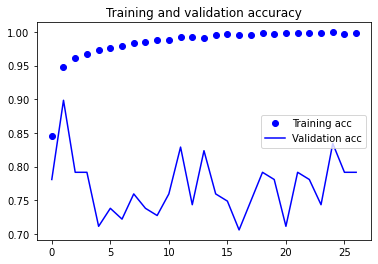

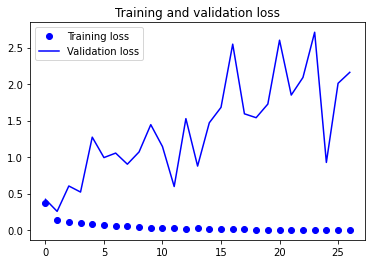

In [61]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Comments**

As we can see, the model is quite overfit. Some possible changes are lowering batch size and adding some regularizers (l2 and dropout). It's worth noting that when fitting a model, it goes from underfit to fit well to overfit. It seems that our model is fitting well very early (by epoch 2) and subsequently proceeding to overfit in the next epochs. So, we will also incorporate a model checkpoint callback to capture the weights of the best model in the case that our next models also converge very quickly.

**CNN Model: Part 2**

In [74]:
train_data_dir = 'data/Pediatric Chest X-ray Pneumonia/train'
test_data_dir = 'data/Pediatric Chest X-ray Pneumonia/test'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=.6)

train_generator_2 = train_datagen.flow_from_directory(
        # This is the target directory
        train_data_dir,
        # All images will be resized to 250x250
        target_size=(255, 255),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator_2 = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(255, 255),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        subset='validation')

test_generator_2 = test_datagen.flow_from_directory(test_data_dir,
                                                        target_size=(255, 255),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        subset='training')

Found 5232 images belonging to 2 classes.
Found 374 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


In [108]:
%reset_selective -f cnn_2
%reset_selective -f history_2

In [109]:
# early stopping callback after 5 consecutive iterations with no improvement to validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# model checkpoint call back
checkpoint_filepath = 'model_checkpoints/cnn_2_model/weights.best.hdf5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               monitor='val_acc',
                                                               mode='max',
                                                               verbose=1,
                                                               save_best_only=True)

In [110]:
cnn_2_model = Sequential()
cnn_2_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
cnn_2_model.add(MaxPooling2D((2, 2)))
cnn_2_model.add(Dropout(.3))                

cnn_2_model.add(Flatten())
cnn_2_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
cnn_2_model.add(Dropout(.2)) 
cnn_2_model.add(Dense(1, activation='sigmoid'))
cnn_2_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [111]:
start = datetime.datetime.now()
history_2 = cnn_2_model.fit_generator(train_generator_2,  
                              epochs=30,
                              validation_data=validation_generator_2,
                              callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/30
164/164 [==============================] - ETA: 0s - loss: 1.8255 - acc: 0.8941
Epoch 00001: val_acc improved from -inf to 0.81551, saving model to model_checkpoints/cnn_2_model/weights.best.hdf5
164/164 [==============================] - 158s 963ms/step - loss: 1.8255 - acc: 0.8941 - val_loss: 0.6958 - val_acc: 0.8155
Epoch 2/30
164/164 [==============================] - ETA: 0s - loss: 0.3537 - acc: 0.9323
Epoch 00002: val_acc improved from 0.81551 to 0.84225, saving model to model_checkpoints/cnn_2_model/weights.best.hdf5
164/164 [==============================] - 163s 991ms/step - loss: 0.3537 - acc: 0.9323 - val_loss: 0.5084 - val_acc: 0.8422
Epoch 3/30
164/164 [==============================] - ETA: 0s - loss: 0.3012 - acc: 0.9402
Epoch 00003: val_acc did not improve from 0.84225
164/164 [==============================] - 169s 1s/step - loss: 0.3012 - acc: 0.9402 - val_loss: 0.6504 - val_acc: 0.7968
Epoch 4/30
164/164 [==============================] - ETA: 0s - loss: 

In [112]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:34:51.072403


**Evaluate Best Model**

Again, the model seems to fit very quickly, reaching a good fit by epoch 12. In addition, the validation loss hadn't improved for 5 consecutive epochs, triggering the early stop. Let's look at how the model fares on the test set.

In [113]:
# get best weights
cnn_2_best_model = Sequential()
cnn_2_best_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
cnn_2_best_model.add(MaxPooling2D((2, 2)))
cnn_2_best_model.add(Dropout(.3))                

cnn_2_best_model.add(Flatten())
cnn_2_best_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
cnn_2_best_model.add(Dropout(.2)) 
cnn_2_best_model.add(Dense(1, activation='sigmoid'))

cnn_2_best_model.load_weights("model_checkpoints/cnn_2_model/weights.best.hdf5")
cnn_2_best_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [114]:
score_cnn_2 = cnn_2_best_model.evaluate(test_generator_2)

8/8 [==============================] - 3s 363ms/step - loss: 0.4768 - acc: 0.8600


**Comments**

The weights on this model seem relatively good (albeit maybe a little overfit). To summarize, we achieved loss-accuracy of:
- Training: .3003 - .9480
- Validation: .4972 - .8797
- Test: .4768 - .8600

The model does perform better on the training than the validation or the test, yet seems to have relatively high performance for all three sets. The next model lowers the learning rate of Adam to see if that has an effect on convergence speed

**CNN Model: Part 3**

In [87]:
%reset_selective -f cnn_3

In [88]:
# early stopping callback after 5 consecutive iterations with no improvement to validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# model checkpoint call back
checkpoint_filepath = 'model_checkpoints/cnn_3_model/weights.best.hdf5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               monitor='val_acc',
                                                               mode='max',
                                                               verbose=1,
                                                               save_best_only=True)

In [91]:
cnn_3_model = Sequential()
cnn_3_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))
cnn_3_model.add(MaxPooling2D((2, 2)))
cnn_3_model.add(Dropout(.3))                
cnn_3_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_3_model.add(MaxPooling2D((2, 2)))
cnn_3_model.add(Dropout(.3)) 
cnn_3_model.add(Flatten())
cnn_3_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
cnn_3_model.add(Dropout(.2)) 
cnn_3_model.add(Dense(1, activation='sigmoid'))
cnn_3_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

In [92]:
start = datetime.datetime.now()
cnn_3_history = cnn_3_model.fit_generator(train_generator,  
                              epochs=30,
                              validation_data=validation_generator,
                              callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/30
82/82 [==============================] - ETA: 0s - loss: 2.6722 - acc: 0.7141
Epoch 00001: val_acc improved from -inf to 0.64706, saving model to model_checkpoints/cnn_3_model/weights.best.hdf5
82/82 [==============================] - 206s 3s/step - loss: 2.6722 - acc: 0.7141 - val_loss: 1.4014 - val_acc: 0.6471
Epoch 2/30
82/82 [==============================] - ETA: 0s - loss: 0.8408 - acc: 0.8918
Epoch 00002: val_acc improved from 0.64706 to 0.90909, saving model to model_checkpoints/cnn_3_model/weights.best.hdf5
82/82 [==============================] - 193s 2s/step - loss: 0.8408 - acc: 0.8918 - val_loss: 0.7220 - val_acc: 0.9091
Epoch 3/30
82/82 [==============================] - ETA: 0s - loss: 0.4710 - acc: 0.9362
Epoch 00003: val_acc did not improve from 0.90909
82/82 [==============================] - 194s 2s/step - loss: 0.4710 - acc: 0.9362 - val_loss: 0.5710 - val_acc: 0.8289
Epoch 4/30
82/82 [==============================] - ETA: 0s - loss: 0.3244 - acc: 0.9503

In [104]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 1:04:44.917534


In [2]:
# Get best weights
cnn_3_best_model = Sequential()
cnn_3_best_model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(255, 255, 3)))
cnn_3_best_model.add(MaxPooling2D((2, 2)))
cnn_3_best_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_3_best_model.add(MaxPooling2D((2, 2)))

cnn_3_best_model.add(Flatten())
cnn_3_best_model.add(Dense(256, activation='relu'))
cnn_3_best_model.add(Dense(1, activation='sigmoid'))

cnn_3_best_model.load_weights("model_checkpoints/cnn_3_model/weights.best.hdf5")

In [3]:
cnn_3_best_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

In [9]:
score = cnn_3_best_model.evaluate(test_generator)

4/4 [==============================] - 2s 573ms/step - loss: 0.3477 - acc: 0.8720


**Comments**

The best model had almost identical accuracy for validation and training. In fact, validation was slightly higher. The results (loss-accuracy) are as shown:

- Training: .8408 - .8918
- Validation: .7220 - .9091
- Test: .3477 - .8720

Here the accuracies are relatively the same though we see that the test loss is lower than the other two. I would probably choose this model to use as it is the least evident of over-fitting. 

**Model Structure**

In [12]:
pip install pydot==1.2.3

  Created wheel for pydot: filename=pydot-1.2.3-py3-none-any.whl size=18928 sha256=fe9f0365c494809f293d74dec12386dacc5e42bc821fd200e6180dfc22c6c7df
  Stored in directory: /Users/hoganbyun/Library/Caches/pip/wheels/97/f3/4f/2614983209399831c4b278ae354b87b35cdc070703c5c8611d
Successfully built pydot
  Attempting uninstall: pydot
    Found existing installation: pydot 1.4.2
    Uninstalling pydot-1.4.2:
      Successfully uninstalled pydot-1.4.2
Note: you may need to restart the kernel to use updated packages.


In [4]:
from keras.utils.vis_utils import plot_model

plot_model(cnn_3_best_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Interpretation

Let's take a look at an example from the training set of someone with pneumonia.

(1, 255, 255, 3)


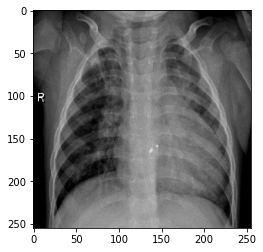

In [10]:
from keras.preprocessing import image

# Load an image from the training set
img_path = 'data/Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1002_bacteria_2933.jpeg'


img = image.load_img(img_path, target_size=(255, 255))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

Next, we want to view how each layer of the model works on the image. From the model summary below, we see that each layer before the flatten layer has 32 or more channels. Thus, we can take a look at a channel of arbitrary number between 1 and 32 to see how each layer works. (In this case we took the 11th channel of each layer).

In [11]:
from keras import models

# Extract model layer outputs
layer_outputs = [layer.output for layer in cnn_3_best_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=cnn_3_best_model.input, outputs=layer_outputs)

In [12]:
cnn_3_best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               62980352  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

**Visualization**

We can see an example of the Conv2D and max pooling layers. In this case, we are looking at the 11th channel of these layers. We can see the max pooling doing its work as the images look more "pixelated" than those of the Conv2D layers. We can also see that later layers are more abstract interpretations of earlier ones.

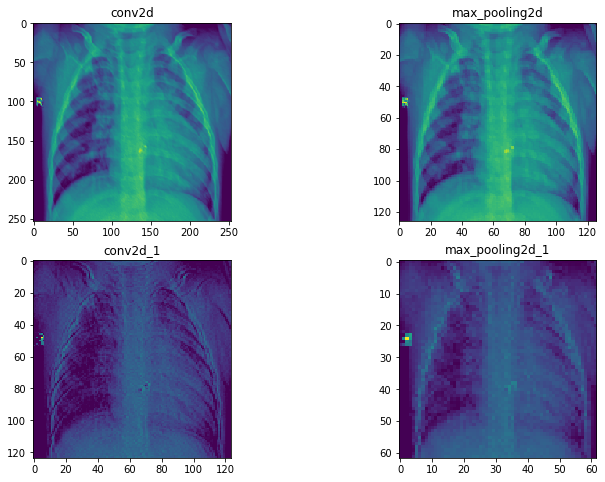

In [22]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

layer_names = []
for layer in cnn_3_best_model.layers[:4]:
    layer_names.append(layer.name)

for i in range(4):
    row = i//2
    column = i%2
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 11], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])